In [1]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] =\
'/Users/shimengfeng/Documents/Master_Columbia/Fall 2019/capstone/BlackLivesMatter/EDA/\
dsi-capstone-f19-group-1-6c986cf239c5.json'

In [2]:
import matplotlib.pyplot as plt
from google.cloud import bigquery

%load_ext google.cloud.bigquery

In [122]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')

In [4]:
bigquery_client = bigquery.Client(project='dsi-capstone-f19-group-1')

See how retweet count changes over time

In [5]:
%%bigquery df_date
select EXTRACT(DATE from created_at) as date, count(*) as count_tweets, 
        count(distinct id) as unique_id,
        count(distinct user_id) as unique_user_id,
        sum(cast(user_verified as INT64)) as num_verified
from tweets.all_tweets group by 1;

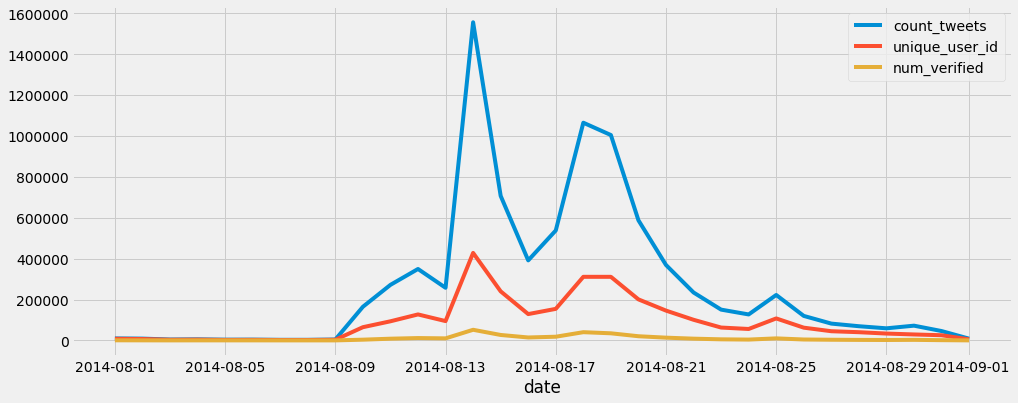

In [148]:
ax = df_date.plot(x='date',
             y='count_tweets',
             kind='line',
             figsize=(15,6))
df_date.plot(x='date',
            y='unique_user_id',
            kind='line',
            ax=ax)
df_date.plot(x='date',
            y='num_verified',
            kind='line',
            ax=ax)

In [6]:
%%bigquery retweet_time
select date, sum(retweet_max) as retweet_cnt
from features.retweet_cnt_max
group by date

Text(0, 0.5, 'count')

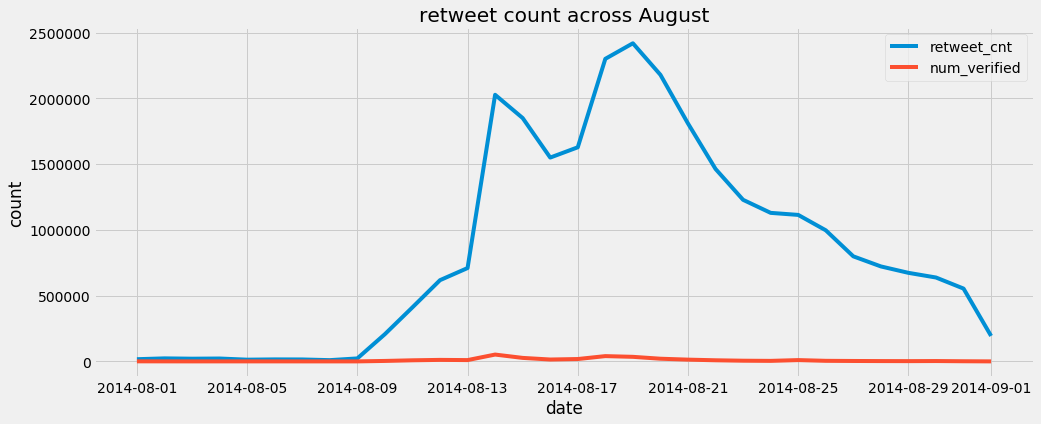

In [109]:
ax = retweet_time.plot(x='date',
             y='retweet_cnt',
             kind='line',
             figsize=(15,6))
df_date.plot(x='date',
            y='num_verified',
            kind='line',
            ax=ax)

plt.title('retweet count across August')
plt.ylabel('count')


See the overall count

In [10]:
%%bigquery df_count
select count(distinct(id)) as tweet_cnt, count(*) as total_count
from tweets.all_tweets

In [101]:
df_count # this show that about 99% of the data have unique id 

,tweet_cnt,total_count
0,8493073,8500890


See how top 10 retweets within in August changes. Has created the retweet_cnt_max table to see the maximum retweet each user created

In [146]:
%%bigquery 
select count( full_text)
from features.retweet

,f0_
0,5696619


In [147]:
# % of retweet
5696619/8500890


0.6701203050504124

In [113]:
%%bigquery df_retweet_top20
select date, full_text, retweet_max
from(
select *, row_number() OVER (PARTITION BY date ORDER BY retweet_max desc) as row_num
from features.retweet_cnt_max) as temp
where temp.row_num<=20

In [114]:
# this is a table shows tweets that got most frequently (days retweeted across 30 days period) tweeted during the month
df_retweet_days_freq = df_retweet_top20.groupby('full_text').count().\
reset_index().rename(columns={'date':'cnt'}).sort_values('cnt',ascending=False)
df_retweet_days_freq.head()

,full_text,cnt,retweet_max
110,RT @chrislhayes: I interviewed the key witness to the Michael Brown shooting last night. \n\nThe police haven't. \n\nThink about that.,20,20
119,RT @jackfrombkln: The Civil Rights Act is 50 years old. These two pictures were taken 50 years apart. Behold our progress. #Ferguson http:/…,19,19
148,"RT @wilw: Hey Media? Maybe instead of sending cameras to Robin Williams’ house to be ghoulish, you could send cameras to #Ferguson to be jo…",18,18
107,RT @attorneycrump: Such a powerful image from the student of Howard University. #MichaelBrown http://t.co/RsuPS8zAhE,17,17
24,RT @BuzzFeed: This “Fresh Prince of Bel-Air” clip has taken on new meaning in the wake of #Ferguson\nhttp://t.co/vgh2AW8iYy http://t.co/plOE…,14,14


In [133]:
%%bigquery
select id, full_text
from tweets.all_tweets
where full_text LIKE 'I interviewed the key witness to the Michael Brown shooting last night%'
limit 1

,id,full_text
0,499275552176734200,I interviewed the key witness to the Michael Brown shooting last night. \n\nThe police haven't. \n\nThink about that.


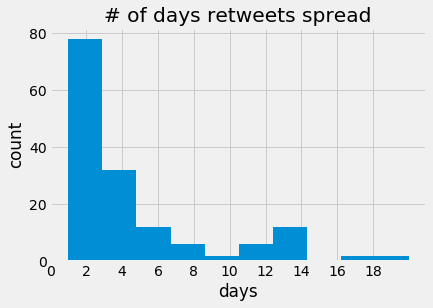

In [127]:
plt. hist(df_retweet_days_freq.cnt, bins =10)
plt.xticks(np.arange(0, 20, step=2))

plt.title ('# of days retweets spread')
plt.xlabel('days')
plt.ylabel('count')
plt.show()

In [36]:
%%bigquery df_average
select date,avg(max_followers) as avg_followers, avg(max_friends) as avg_friends,  avg(retweet_cnt) as avg_retweet_count
from features.user_retweet
group by date


The average should not have significant change

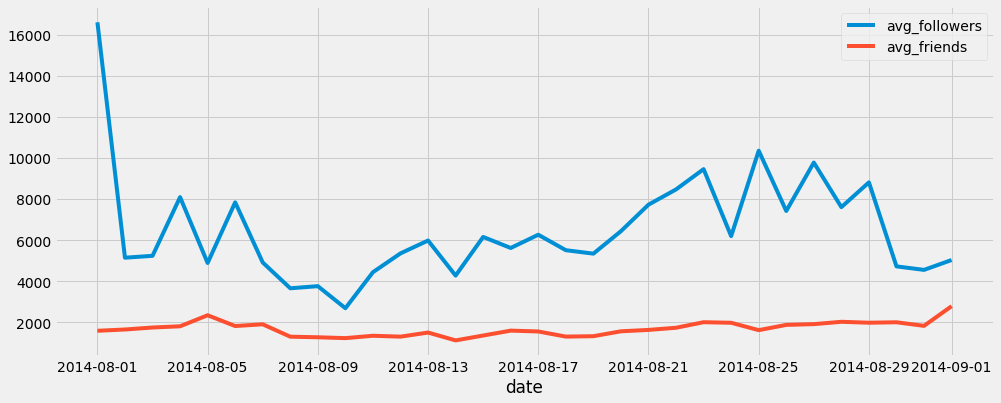

In [40]:
ax = df_average.plot(x='date',
             y='avg_followers',
             kind='line',
             figsize=(15,6))
# df_average.plot(x='date',
#             y='avg_retweet_count',
#             kind='line',
#             ax=ax)
df_average.plot(x='date',
            y='avg_friends',
            kind='line',
            ax=ax)

In [ ]:
#create bins to see the differnet follower num group retweets behavior at August
CONCAT(bucket_floor, ' to ', bucket_ceiling) as bucket_name,

In [47]:
%%bigquery
select max(max_followers)
from features.user_retweet


,f0_
0,71591982


In [60]:
%%bigquery 
select * 
from features.user_retweet
limit 10

,date,user_id,retweet_cnt,max_followers,max_friends,max_fav
0,2014-08-08,2206793891,14,1528,989,4371
1,2014-08-01,1944832135,21,1174,0,14
2,2014-09-01,555984374,11,8183,3214,35747
3,2014-09-01,1884645062,43,272,91,13964
4,2014-09-01,544789480,19,515,951,129172
5,2014-08-05,1237920517,19,1247,1338,3714
6,2014-09-01,2747704116,32,46,278,343
7,2014-09-01,2754059234,16,51,180,537
8,2014-08-08,2416786801,13,262,444,929
9,2014-09-01,25429149,11,2024,4794,65287


The following shows how differnet gorup influence it differently. But since the average user will have about 10000 followers, it will make more sense to separate out the users who have more than 10000 followers and see their retweet changes

In [150]:
%%bigquery df_pop_retweet
select A. date, A. influencer_retweet, B. non_influencer_retweet 
from 
(select date, sum(retweet_cnt)/count(*) as influencer_retweet 
from features.user_retweet
where max_followers >10000
group by date) A 
join 

(select date, sum(retweet_cnt)/count(*) as non_influencer_retweet 
from features.user_retweet
where max_followers <10000
group by date) B

on A.date =B.date

Text(0, 0.5, 'adjusted retweet count')

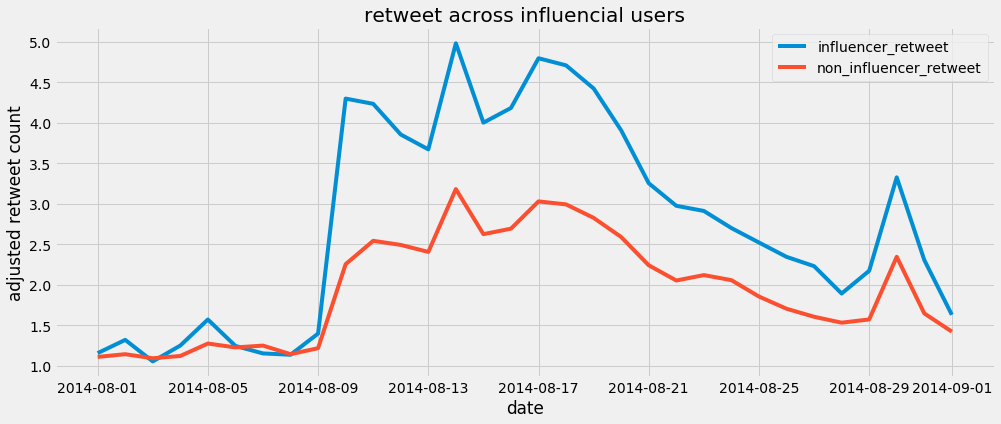

In [152]:
ax = df_pop_retweet.plot(x='date',
             y='influencer_retweet',
             kind='line',
             figsize=(15,6))
df_pop_retweet.plot(x='date',
            y='non_influencer_retweet',
            kind='line',
            ax=ax)
plt.title('retweet across influencial users')
plt.xlabel('date')
plt.ylabel('adjusted retweet count')

In [94]:
%%bigquery df_user_retweet_14
select 
date, bucket_floor,

sum(retweet_cnt) as retweet_total,count(*) as count

from (
select 
floor(max_followers/200000)*200000 as bucket_floor,
floor(max_followers/200000)*200000+200000 as bucket_ceiling, retweet_cnt, date
from features.user_retweet
) a
where a.date = '2014-08-14'
group by 1,2
order by 1,2



In [34]:
%%bigquery df_user_retweet
select * 
from features.user_retweet
order by max_followers desc, retweet_cnt desc
limit 100

,date,user_id,retweet_cnt,max_followers,max_friends,max_fav
0,2014-08-15,10228272,1,71591982,1034,2454
1,2014-08-17,26565946,1,64991903,288,423
2,2014-08-25,428333,3,55889974,121,22
3,2014-08-18,428333,2,55886423,121,22
4,2014-08-23,428333,2,55885868,121,22
5,2014-08-22,428333,1,55884164,121,22
6,2014-08-21,428333,3,55883854,121,22
7,2014-08-20,428333,9,55883781,121,22
8,2014-08-19,428333,1,55883214,121,22
9,2014-08-15,428333,1,55334227,121,21


In [284]:
# retweet counts across hashtags

contributors coordinates                created_at display_text_range  \
0                          2014-08-15 14:30:21+00:00  [0, 138]            
1                          2014-08-14 15:47:29+00:00  [0, 96]             
2                          2014-08-15 00:37:49+00:00  [0, 96]             
3                          2014-08-29 17:08:35+00:00  [0, 112]            
4                          2014-08-14 16:11:28+00:00  [0, 140]            
5                          2014-08-21 01:18:46+00:00  [0, 144]            
6                          2014-08-01 20:04:30+00:00  [0, 83]             
7                          2014-08-14 01:19:30+00:00  [0, 108]            
8                          2014-08-18 03:47:28+00:00  [0, 101]            
9                          2014-08-19 05:40:53+00:00  [0, 139]            

   favorite_count  favorited  \
0  0               False       
1  0               False       
2  0               False       
3  0               False       
4  0               False       
5  0               False       
6  0               False       
7  0               False       
8  0               False       
9  0               False       

                                                                                                                                          full_text  \
0  RT @cnnbrk: Police name the officer who shot Missouri teen Michael Brown; say he's been police officer for 6 years. http://t.co/mTdbkOZbbE         
1  RT @JoyAnnReid: The president will speak at 12:15 p.m. ... expected topics to include #Ferguson.                                                   
2  RT @eilatan: New post: I've compiled some links about #Ferguson: 08/14/14 http://t.co/RWaUpSvJob                                                   
3  RT @TPM: #Ferguson protesters sue Missouri police for $40 million: http://t.co/lbZX6oFXgh http://t.co/rWmwEuRIlt                                   
4  RT @FergusonUnity: It's not that history is repeating itself. Just it never really changed in the first place. Only Disguised #Ferguson htt…       
5  RT @Jeffwrcct: Been @ Ground Zero in #Ferguson for 5 mins &amp; police already arrested someone in the crowd when protestors were marching, for…   
6  RT @amNewYork: Eric Garner's death has been ruled a homicide http://t.co/VFU16pcwSg                                                                
7  RT @YourAnonNews: Notice it is only freedom of the press when it is "their press"? #Ferguson FIRST AMENDMENT                                       
8  RT @mattdpearce: Autopsy: Michael Brown was shot six times, twice in the head. http://t.co/n4bVglz9yj                                              
9  RT @VibeMagazine: .@iamdiddy calls out President Obama on #Ferguson: "These are your People!" http://t.co/6qt1fumSm0 http://t.co/IZLoQ2ss52        

  latitude longitude                  id              id_str  \
0  None     None      500288387354730500  500288387354730497   
1  None     None      499945413181730800  499945413181730816   
2  None     None      500078873371893760  500078873371893761   
3  None     None      505401639994261500  505401639994261504   
4  None     None      499951446625120260  499951446625120256   
5  None     None      502263508877066240  502263508877066242   
6  None     None      495299049751212000  495299049751212033   
7  None     None      499726977558126600  499726977558126592   
8  None     None      501213767628517400  501213767628517376   
9  None     None      501604695987585000  501604695987585025   

  in_reply_to_screen_name in_reply_to_status_id in_reply_to_status_id_str  \
0                          None                  None                       
1                          None                  None                       
2                          None                  None                       
3                          None                  None                       
4                          None                  None                  